## DATA 620 - Project 2: Marvel Social Network Universe

**By Eddie Xu and Mohamed Hassan-El Serafi**

For this project:

Instructions:

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?
You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday 

[Kaggle data link](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

In [43]:
# load packages
import pandas as pd
import numpy as np
import networkx as nx
import random
import movecolumn as mc
from scipy import stats
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,10)

# import packages to set up bipartite graph and communities
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from community import community_louvain
import matplotlib.cm as cm

### Data Selection

In [44]:
edges_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/edges.csv'
network_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/hero-network.csv'
nodes_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/nodes.csv' 

# extract data
nodes_raw = pd.read_csv(nodes_url)
edges_raw = pd.read_csv(edges_url)
network_raw = pd.read_csv(network_url)

### Exploratory Data Analysis

#### Nodes

In [45]:
nodes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [46]:
nodes_raw.head(10)

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero
5      4-D MAN/MERCURIO   hero
6               8-BALL/   hero
7                 A '00  comic
8                 A '01  comic
9                 A 100  comic

In [47]:
nodes_profile = ProfileReport(nodes_raw, title="Nodes Profiling Report")
nodes_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Edges

In [48]:
edges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [49]:
edges_raw.head(10)

hero     comic
0  24-HOUR MAN/EMMANUEL    AA2 35
1  3-D MAN/CHARLES CHAN     AVF 4
2  3-D MAN/CHARLES CHAN     AVF 5
3  3-D MAN/CHARLES CHAN     COC 1
4  3-D MAN/CHARLES CHAN    H2 251
5  3-D MAN/CHARLES CHAN    H2 252
6  3-D MAN/CHARLES CHAN  M/PRM 35
7  3-D MAN/CHARLES CHAN  M/PRM 36
8  3-D MAN/CHARLES CHAN  M/PRM 37
9  3-D MAN/CHARLES CHAN     WI? 9

In [50]:
edges_profile = ProfileReport(edges_raw, title="Edges Profiling Report")
edges_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Network

In [51]:
network_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [52]:
network_raw.head(10)

hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL
5  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
6  STEELE, SIMON/WOLFGA      FORTUNE, DOMINIC
7  STEELE, SIMON/WOLFGA   ERWIN, CLYTEMNESTRA
8  STEELE, SIMON/WOLFGA  IRON MAN/TONY STARK 
9  STEELE, SIMON/WOLFGA  IRON MAN IV/JAMES R.

In [53]:
network_profile = ProfileReport(network_raw, title="Network Profiling Report")
network_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Transformation

In [54]:
# For unipartite graph
# create the hero network
Thor_network = network_raw[network_raw['hero1'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_network = network_raw[network_raw['hero1'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_network = network_raw[network_raw['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_network = network_raw[network_raw['hero1'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_network = network_raw[network_raw['hero1'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger networks into one
network_subset = pd.concat([Thor_network, Cap_network, IronMan_network, BlackWidow_network, Hulk_network],axis = 0)

In [55]:
## for bipartite graph
# create the avenger list
avenger_list = ['THOR/DR. DONALD BLAK', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'BLACK WIDOW/NATASHA', 'HULK/DR. ROBERT BRUC']

# extract edges of original avengers except for hawkeyes as there is no data for it
Thor_edge = edges_raw[edges_raw['hero'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_edge = edges_raw[edges_raw['hero'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_edge = edges_raw[edges_raw['hero'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_edge = edges_raw[edges_raw['hero'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_edge = edges_raw[edges_raw['hero'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger edges into one
edge_subset = pd.concat([Thor_edge, Cap_edge, IronMan_edge, BlackWidow_edge, Hulk_edge],axis = 0)
edge_list = list(zip(edge_subset['hero'], edge_subset['comic']))

# create the comic list
comic_list = edge_subset['comic']

### Network Analysis

#### Unipartite Network

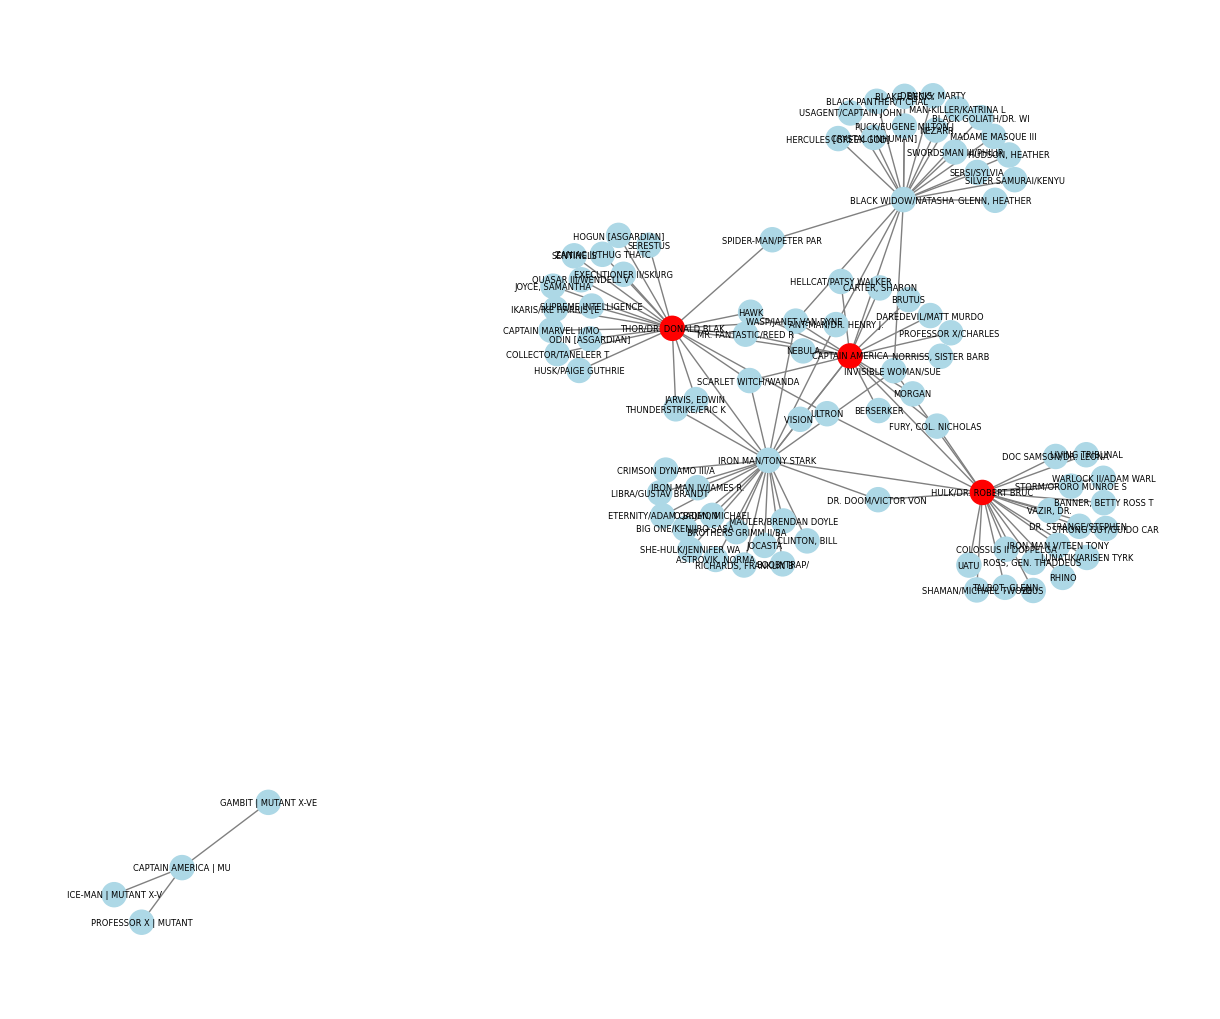

In [95]:
G=nx.from_pandas_edgelist(network_subset, 'hero1', 'hero2')

avenger_color = ["red" if node in avenger_list else "lightblue" for node in G.nodes()]

pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_color=avenger_color, edge_color="gray", node_size=300, font_size=6, font_color="black")

plt.show()

#### Network Centrality

### Degree Centrality

In [57]:
# get the degree centrality
avenger_centrality = nx.degree_centrality(G)
sorted_avenger_centrality = sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Degree Centrality:", sorted_avenger_centrality)
sorted_avenger_centrality

Top Avenger by Degree Centrality: [('IRON MAN/TONY STARK ', 0.2777777777777778), ('THOR/DR. DONALD BLAK', 0.2555555555555556), ('HULK/DR. ROBERT BRUC', 0.2555555555555556), ('BLACK WIDOW/NATASHA ', 0.23333333333333334), ('CAPTAIN AMERICA', 0.2111111111111111), ('WASP/JANET VAN DYNE ', 0.044444444444444446), ('SCARLET WITCH/WANDA ', 0.03333333333333333), ('CAPTAIN AMERICA | MU', 0.03333333333333333), ('INVISIBLE WOMAN/SUE ', 0.03333333333333333), ('MR. FANTASTIC/REED R', 0.022222222222222223)]


[('IRON MAN/TONY STARK ', 0.2777777777777778),
 ('THOR/DR. DONALD BLAK', 0.2555555555555556),
 ('HULK/DR. ROBERT BRUC', 0.2555555555555556),
 ('BLACK WIDOW/NATASHA ', 0.23333333333333334),
 ('CAPTAIN AMERICA', 0.2111111111111111),
 ('WASP/JANET VAN DYNE ', 0.044444444444444446),
 ('SCARLET WITCH/WANDA ', 0.03333333333333333),
 ('CAPTAIN AMERICA | MU', 0.03333333333333333),
 ('INVISIBLE WOMAN/SUE ', 0.03333333333333333),
 ('MR. FANTASTIC/REED R', 0.022222222222222223)]

In [58]:
avenger_degree_df = pd.DataFrame(sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Degree Centrality'])

In [59]:
avenger_degree_df

Name  Degree Centrality
0  IRON MAN/TONY STARK            0.277778
1  THOR/DR. DONALD BLAK           0.255556
2  HULK/DR. ROBERT BRUC           0.255556
3  BLACK WIDOW/NATASHA            0.233333
4       CAPTAIN AMERICA           0.211111
5  WASP/JANET VAN DYNE            0.044444
6  SCARLET WITCH/WANDA            0.033333
7  CAPTAIN AMERICA | MU           0.033333
8  INVISIBLE WOMAN/SUE            0.033333
9  MR. FANTASTIC/REED R           0.022222

### Betweenness Centrality

In [60]:
# get the betweeness centrality
avenger_betweeness_centrality = nx.betweenness_centrality(G)
sorted_betweeness_centrality = sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Betweeness Centrality:", sorted_betweeness_centrality)
sorted_betweeness_centrality

Top Avenger by Betweeness Centrality: [('IRON MAN/TONY STARK ', 0.3498198680221156), ('HULK/DR. ROBERT BRUC', 0.3391926758218893), ('CAPTAIN AMERICA', 0.3368616610189642), ('BLACK WIDOW/NATASHA ', 0.3163212650853102), ('THOR/DR. DONALD BLAK', 0.28653468878187954), ('INVISIBLE WOMAN/SUE ', 0.058495333214434314), ('WASP/JANET VAN DYNE ', 0.039708102966529955), ('ULTRON', 0.021872659176029964), ('SPIDER-MAN/PETER PAR', 0.021870281196123893), ('ANT-MAN/DR. HENRY J.', 0.017837821770406038)]


[('IRON MAN/TONY STARK ', 0.3498198680221156),
 ('HULK/DR. ROBERT BRUC', 0.3391926758218893),
 ('CAPTAIN AMERICA', 0.3368616610189642),
 ('BLACK WIDOW/NATASHA ', 0.3163212650853102),
 ('THOR/DR. DONALD BLAK', 0.28653468878187954),
 ('INVISIBLE WOMAN/SUE ', 0.058495333214434314),
 ('WASP/JANET VAN DYNE ', 0.039708102966529955),
 ('ULTRON', 0.021872659176029964),
 ('SPIDER-MAN/PETER PAR', 0.021870281196123893),
 ('ANT-MAN/DR. HENRY J.', 0.017837821770406038)]

In [61]:
avenger_betweenness_df = pd.DataFrame(sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Betweenness Centrality'])

In [62]:
avenger_betweenness_df

Name  Betweenness Centrality
0  IRON MAN/TONY STARK                 0.349820
1  HULK/DR. ROBERT BRUC                0.339193
2       CAPTAIN AMERICA                0.336862
3  BLACK WIDOW/NATASHA                 0.316321
4  THOR/DR. DONALD BLAK                0.286535
5  INVISIBLE WOMAN/SUE                 0.058495
6  WASP/JANET VAN DYNE                 0.039708
7                ULTRON                0.021873
8  SPIDER-MAN/PETER PAR                0.021870
9  ANT-MAN/DR. HENRY J.                0.017838

### Closeness Centrality

In [63]:
# get the closenss centrality
avenger_closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Closeness Centrality:", sorted_closeness_centrality)
sorted_closeness_centrality

Top Avenger by Closeness Centrality: [('CAPTAIN AMERICA', 0.5371096586782862), ('IRON MAN/TONY STARK ', 0.5041581458759372), ('HULK/DR. ROBERT BRUC', 0.4590937306021105), ('THOR/DR. DONALD BLAK', 0.45152625152625153), ('WASP/JANET VAN DYNE ', 0.44420420420420426), ('INVISIBLE WOMAN/SUE ', 0.4257915947035118), ('BLACK WIDOW/NATASHA ', 0.41295365717476273), ('SCARLET WITCH/WANDA ', 0.4068206820682068), ('ANT-MAN/DR. HENRY J.', 0.38581116327595205), ('FURY, COL. NICHOLAS ', 0.3786994367639529)]


[('CAPTAIN AMERICA', 0.5371096586782862),
 ('IRON MAN/TONY STARK ', 0.5041581458759372),
 ('HULK/DR. ROBERT BRUC', 0.4590937306021105),
 ('THOR/DR. DONALD BLAK', 0.45152625152625153),
 ('WASP/JANET VAN DYNE ', 0.44420420420420426),
 ('INVISIBLE WOMAN/SUE ', 0.4257915947035118),
 ('BLACK WIDOW/NATASHA ', 0.41295365717476273),
 ('SCARLET WITCH/WANDA ', 0.4068206820682068),
 ('ANT-MAN/DR. HENRY J.', 0.38581116327595205),
 ('FURY, COL. NICHOLAS ', 0.3786994367639529)]

In [64]:
avenger_closeness_df = pd.DataFrame(sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Closeness Centrality'])

In [65]:
avenger_closeness_df

Name  Closeness Centrality
0       CAPTAIN AMERICA              0.537110
1  IRON MAN/TONY STARK               0.504158
2  HULK/DR. ROBERT BRUC              0.459094
3  THOR/DR. DONALD BLAK              0.451526
4  WASP/JANET VAN DYNE               0.444204
5  INVISIBLE WOMAN/SUE               0.425792
6  BLACK WIDOW/NATASHA               0.412954
7  SCARLET WITCH/WANDA               0.406821
8  ANT-MAN/DR. HENRY J.              0.385811
9  FURY, COL. NICHOLAS               0.378699

### Eigenvector Centrality

In [66]:
avenger_eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Eigenvector Centrality:", sorted_eigenvector_centrality)
sorted_eigenvector_centrality

Top Avenger by Eigenvector Centrality: [('IRON MAN/TONY STARK ', 0.4464469756112587), ('CAPTAIN AMERICA', 0.3879944613202888), ('THOR/DR. DONALD BLAK', 0.37678726281703506), ('HULK/DR. ROBERT BRUC', 0.29273195253573875), ('WASP/JANET VAN DYNE ', 0.20644389058752036), ('BLACK WIDOW/NATASHA ', 0.202102850446607), ('SCARLET WITCH/WANDA ', 0.17692173896064256), ('INVISIBLE WOMAN/SUE ', 0.13749352091951592), ('VISION ', 0.12188571972094045), ('JARVIS, EDWIN ', 0.12024773730840863)]


[('IRON MAN/TONY STARK ', 0.4464469756112587),
 ('CAPTAIN AMERICA', 0.3879944613202888),
 ('THOR/DR. DONALD BLAK', 0.37678726281703506),
 ('HULK/DR. ROBERT BRUC', 0.29273195253573875),
 ('WASP/JANET VAN DYNE ', 0.20644389058752036),
 ('BLACK WIDOW/NATASHA ', 0.202102850446607),
 ('SCARLET WITCH/WANDA ', 0.17692173896064256),
 ('INVISIBLE WOMAN/SUE ', 0.13749352091951592),
 ('VISION ', 0.12188571972094045),
 ('JARVIS, EDWIN ', 0.12024773730840863)]

In [67]:
avenger_eigenvector_df = pd.DataFrame(sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Eigenvector Centrality'])

In [68]:
avenger_eigenvector_df

Name  Eigenvector Centrality
0  IRON MAN/TONY STARK                 0.446447
1       CAPTAIN AMERICA                0.387994
2  THOR/DR. DONALD BLAK                0.376787
3  HULK/DR. ROBERT BRUC                0.292732
4  WASP/JANET VAN DYNE                 0.206444
5  BLACK WIDOW/NATASHA                 0.202103
6  SCARLET WITCH/WANDA                 0.176922
7  INVISIBLE WOMAN/SUE                 0.137494
8               VISION                 0.121886
9        JARVIS, EDWIN                 0.120248

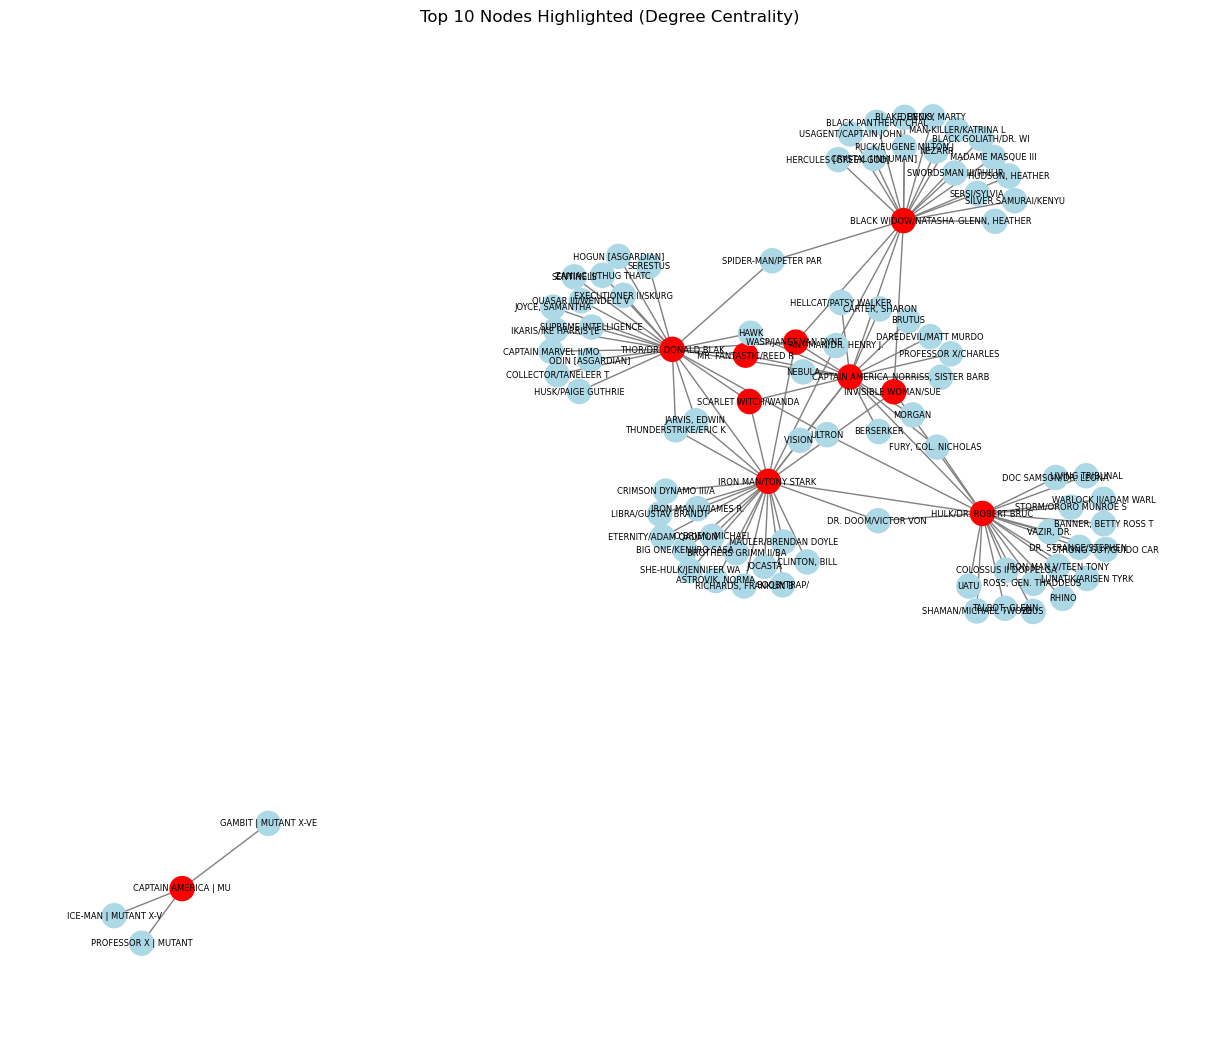

In [ ]:
# extract the top 10 nodes by degree centrality from the sampled graph
top_nodes = [node for node, _ in sorted_avenger_centrality]

# assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes else "lightblue" for node in G.nodes()]

# plot the network with highlighted top nodes
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Nodes Highlighted (Degree Centrality)")
plt.show()

#### Bipartite Network

In [ ]:
# create the bipartite graph
avenger_bipart = nx.Graph()

# add nodes and edges
avenger_bipart.add_nodes_from(comic_list, bipartite=0)
avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
avenger_bipart.add_edges_from(edge_list)

# check if the graph is bipartite
print(bipartite.is_bipartite(avenger_bipart)) 

bipartite_none = list()
# Examine the bipartite attribute of each node
for node, data in avenger_bipart.nodes(data=True):
    if data.get('bipartite') == None:
        print(f"Node {node}: bipartite = {data.get('bipartite')}")
        bipartite_none.append(node)

True


In [71]:
# remove nodes that have NONE bipartite
avenger_bipart.remove_nodes_from(bipartite_none)

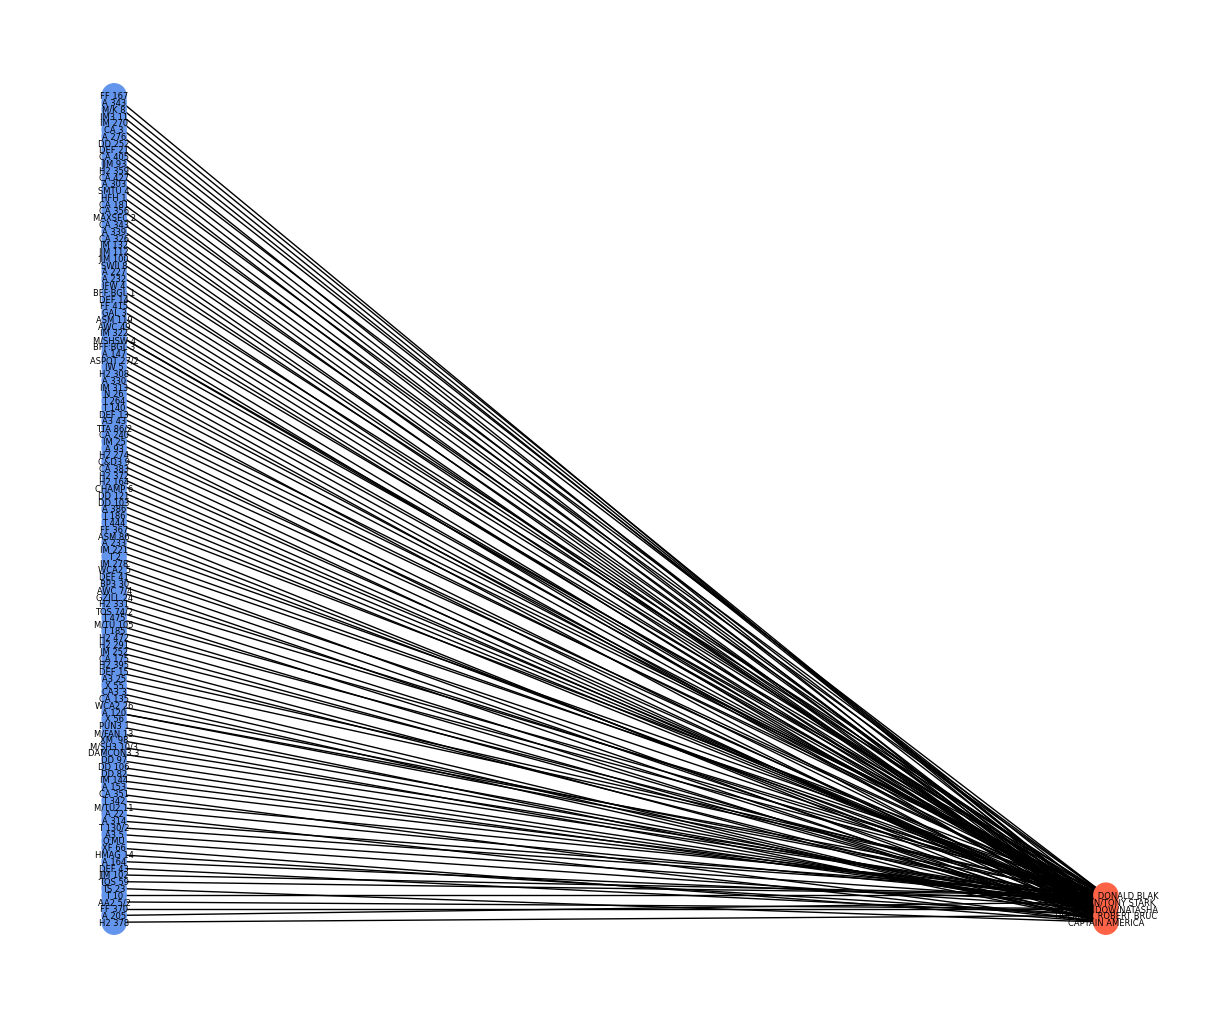

In [72]:
# separate nodes
top_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 0}
bottom_nodes_subset = set(avenger_bipart) - top_nodes_subset
avenger_bipart.nodes(data=True)

# set node colors
color_dict = {0:'cornflowerblue', 1:'tomato'}
color_list = [color_dict[i[1]] for i in avenger_bipart.nodes.data('bipartite')]

# draw a bipartite graph
pos = dict()
color = []
pos.update((n, (1, i)) for i, n in enumerate(top_nodes_subset)) 
pos.update((n, (2, i)) for i, n in enumerate(bottom_nodes_subset)) 
nx.draw(avenger_bipart, pos=pos, with_labels=True, node_color=color_list, font_size=6)
plt.show()


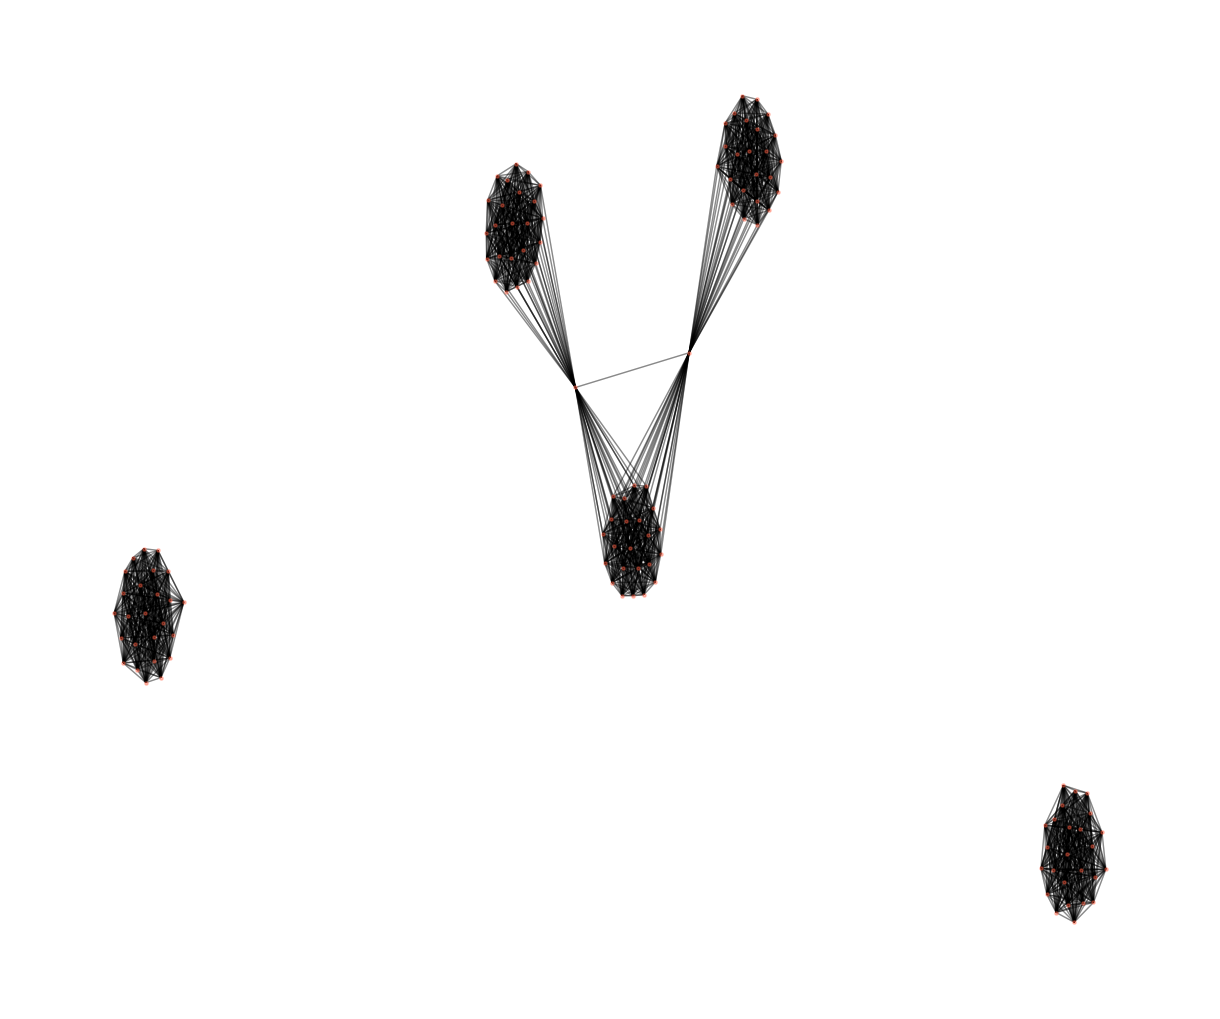

In [73]:
avenger_graph = bipartite.projected_graph(avenger_bipart, comic_list, multigraph=False)

pos=nx.spring_layout(avenger_graph)
nx.draw(avenger_graph, pos=pos, node_size=5, node_color='tomato', alpha=0.4)
nx.draw_networkx_edges(avenger_graph, pos=pos, alpha=0.1)
plt.show()

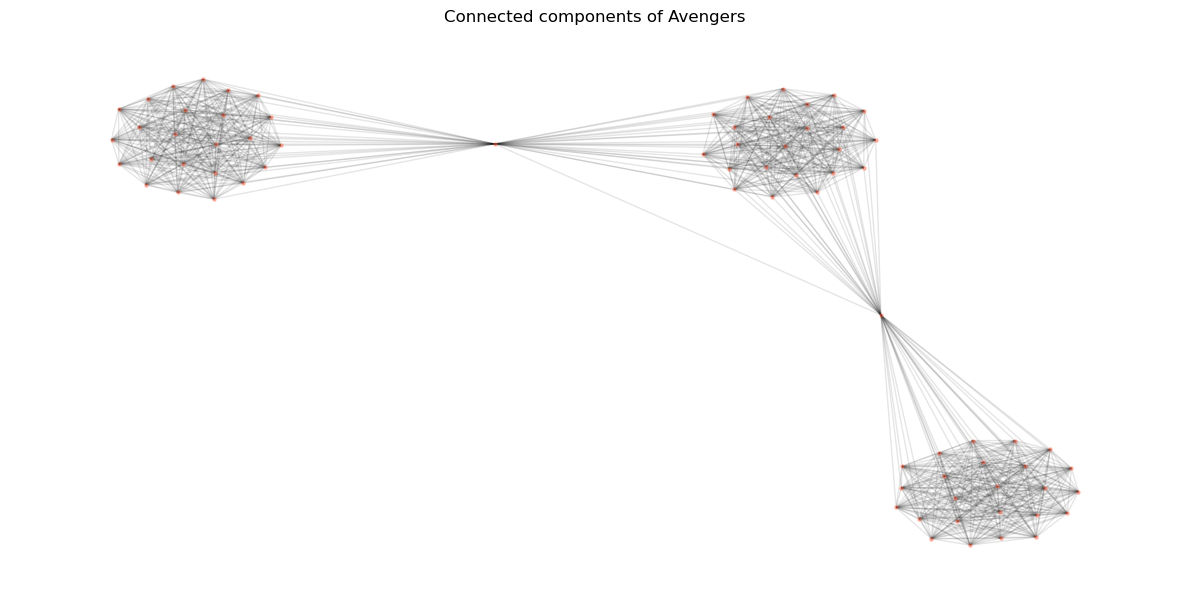

In [74]:
# Ranking of nodes regarding the number of degrees
degree_sequence = sorted([d for n, d in avenger_graph.degree()], reverse=True)

# Extract connected nodes to visualize
Gcc = avenger_graph.subgraph(sorted(nx.connected_components(avenger_graph), key=len, reverse=True)[0])

# Visualization
fig = plt.figure("Degree of the avenger graph")
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5, alpha=0.4, node_color='tomato')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Avengers")
ax0.set_axis_off()

fig.tight_layout()
plt.show()

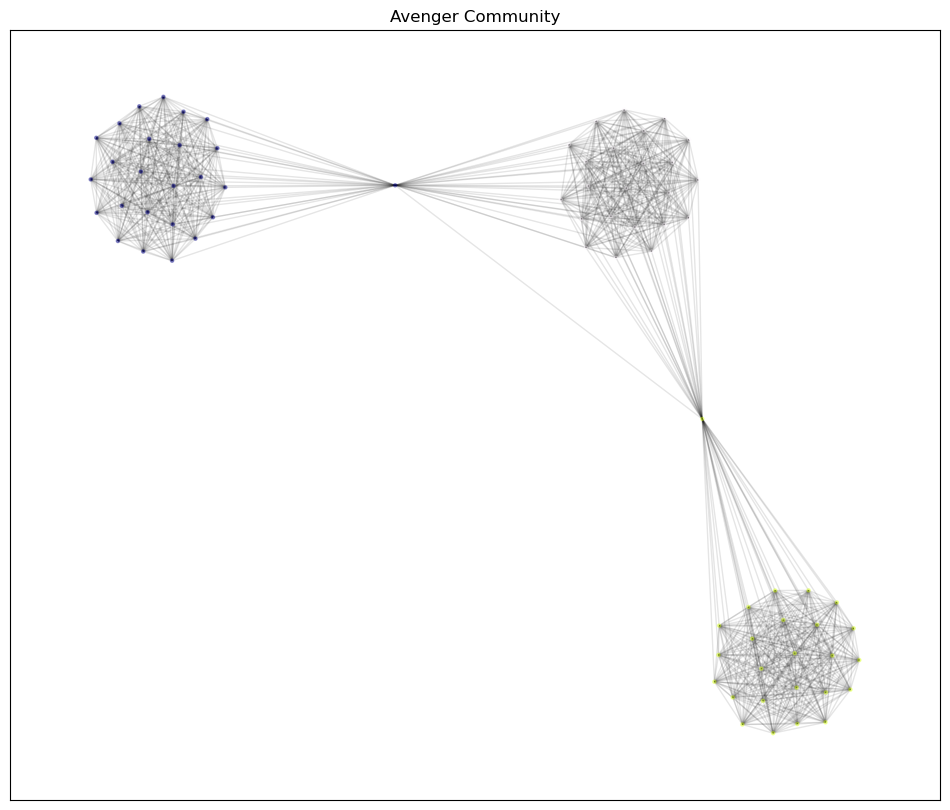

In [75]:
# Community division
partition_avenger = community_louvain.best_partition(Gcc)

# Color the nodes according to community
cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)

pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_avenger.keys(), node_size=5, alpha=0.4,
                       cmap=cmap, node_color=list(partition_avenger.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Avenger Community")
plt.show()